#### üìä train.ipynb

### Libraries and environment

In [1]:
import sys
import os
# Add project root to sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
from utils.paths import MODELS_DIR, DATA_DIR, ARCHITECTURES_DIR

In [2]:
# CIFAR10-Classifier and config.py
from core.cifar10_classifier import CIFAR10Classifier
import config

# libraries
import torch
from torchvision import transforms

In [3]:
# visualization
from utils.visualization import show_random_samples, show_class_distribution

In [4]:
# seed and deterministic
from utils.utils import set_seed, set_deterministic, load_architecture
set_seed(config.SEED)
set_deterministic(
    deterministic=config.DETERMINISTIC,
    benchmark=config.BENCHMARK
)

üß¨ Setting seed: 42


### Loading Model Architecture

In [5]:
# architecture
model_name = "cnn_mixup_cutout_SGD"
metrics_path = os.path.join(MODELS_DIR, model_name, f"{model_name}_metrics.json")

(
    model_class, model_kwargs,activation_fn_name,
    optimizer_cfg, criterion_cfg, lr_scheduler_cfg,
    augmentation, grayscale
) = load_architecture(model_name,base_dir=ARCHITECTURES_DIR)

activation_fn_name = "ReLU"

# training parameters
#optimizer_name = "SGD"
#optimizer_kwargs = {"lr": 0.01, "momentum": 0.9}
#optimizer_name = "Adam"
#optimizer_kwargs = {"lr": 0.0005}
optimizer_name = optimizer_cfg["name"]
optimizer_kwargs = optimizer_cfg["kwargs"]  

#criterion_name = "CrossEntropyLoss"
#criterion_kwargs = {}
criterion_name = criterion_cfg["name"]
criterion_kwargs = criterion_cfg["kwargs"]

# lr_scheduler_name = "StepLR"
# lr_scheduler_kwargs = {"step_size": 10, "gamma": 0.5}
lr_scheduler_name = lr_scheduler_cfg["name"]
lr_scheduler_kwargs = lr_scheduler_cfg["kwargs"]

NUM_EPOCHS = 200
PATIENCE = 10


### Data loading and train/test set preparation

In [6]:
# data loading
from utils.data_utils import (
    compute_mean_std, get_transforms,
    load_cifar10_datasets, split_train_val, create_loaders,
    get_dataset_info
)

# load raw dataset for visualization
raw_dataset, _ = load_cifar10_datasets(
    data_dir=DATA_DIR,
    transform=transforms.ToTensor(),
    subset="train"
)
# extract class names
class_names = raw_dataset.classes

# Normalization
if grayscale:
    transform_gs = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])
mean_std_dataset, _ = load_cifar10_datasets(
    data_dir=DATA_DIR,
    transform=transform_gs if grayscale else transforms.ToTensor(),
    subset="train"
)
# compute mean and std  
mean, std = compute_mean_std(mean_std_dataset)

# Apply transformations
full_transform = get_transforms(mean, std, augmentation=augmentation, grayscale=grayscale)

# Load with transformations
train_dataset, _ = load_cifar10_datasets(data_dir=DATA_DIR, transform=full_transform, subset="train")

# Split
train_subset, val_subset = split_train_val(train_dataset, split_ratio=config.SPLIT_RATIO)

# Loaders
train_loader, val_loader, _ = create_loaders(train_subset=train_subset, val_subset=val_subset, test_dataset=None, batch_size=config.BATCH_SIZE)

üì• Downloading/loading CIFAR-10 datasets to c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10_Torch_Classifier\data... Loading train dataset
Files already downloaded and verified
‚úÖ Loaded training samples: 50000
üì• Downloading/loading CIFAR-10 datasets to c:\Users\pbori\Documents\ML AI Courses\Homework\CIFAR10_Torch_Classifier\data... Loading train dataset
Files already downloaded and verified
‚úÖ Loaded training samples: 50000
üìä Computing mean and std...
‚úÖ Mean: [0.4913996756076813, 0.48215851187705994, 0.4465310275554657], Std: [0.24703219532966614, 0.24348489940166473, 0.2615877091884613]
üß™ Creating transform pipeline...
üß™ Transform pipeline:
  ‚îî‚îÄ RandomCrop(size=(32, 32), padding=4)
  ‚îî‚îÄ ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), saturation=(0.9, 1.1), hue=(-0.1, 0.1))
  ‚îî‚îÄ RandomHorizontalFlip(p=0.5)
  ‚îî‚îÄ RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
  ‚îî‚îÄ RandomAffine(degrees=[0.0, 0.0], t

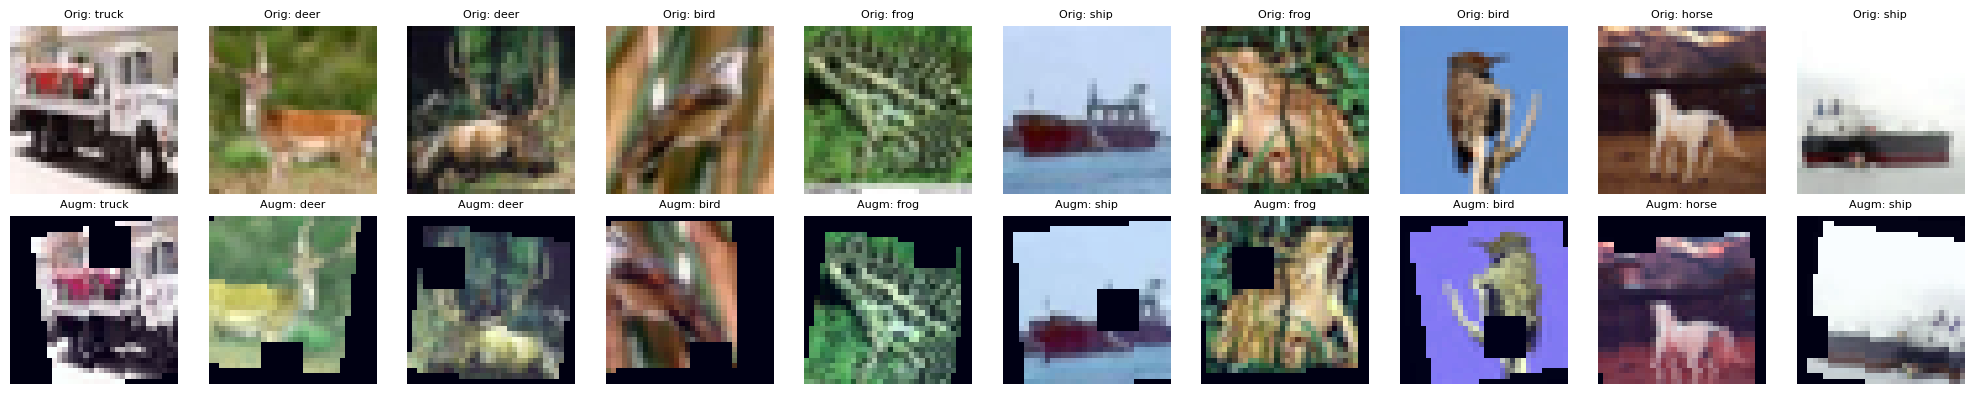

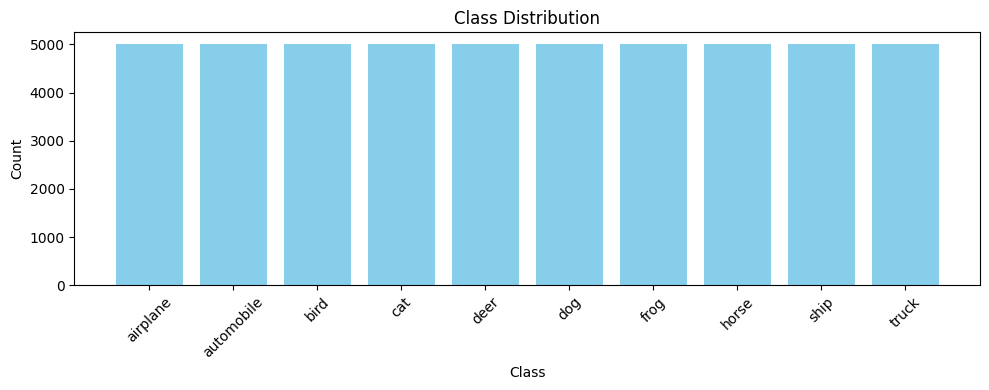

In [7]:
# show random samples and class distribution
show_random_samples(raw_dataset, train_dataset, class_names, n=10)
show_class_distribution(train_dataset, class_names)

In [8]:
# model building and compilation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_shape, num_classes = get_dataset_info(train_dataset)

if grayscale:
    input_shape = (1, input_shape[1], input_shape[2])

model_cls = CIFAR10Classifier(
    name=model_name,
    model_class=model_class,
    model_kwargs=model_kwargs,
    input_shape=input_shape,
    num_classes=num_classes,
    activation_fn_name=activation_fn_name,
    optimizer_name=optimizer_name,
    optimizer_kwargs=optimizer_kwargs,
    criterion_name=criterion_name,
    criterion_kwargs=criterion_kwargs,
    device=device,
    mean=mean.tolist(),
    std=std.tolist(),
    lr_scheduler_name=lr_scheduler_name,
    lr_scheduler_kwargs=lr_scheduler_kwargs,
    augmentation=augmentation,
    grayscale=grayscale
    )
model_cls.build_model()
model_cls.compile()
model_cls.summary()

üîç Extracting dataset info...
‚úÖ Input shape: torch.Size([3, 32, 32]), Number of classes: 10


c:\Users\pbori\Documents\ML AI Courses\Homework\.venv\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Layer (type:depth-idx)                   Output Shape              Param #
CIFAR10_CNN                              [1, 10]                   --
‚îú‚îÄSequential: 1-1                        [1, 256, 2, 2]            --
‚îÇ    ‚îî‚îÄConv2d: 2-1                       [1, 32, 32, 32]           896
‚îÇ    ‚îî‚îÄBatchNorm2d: 2-2                  [1, 32, 32, 32]           64
‚îÇ    ‚îî‚îÄReLU: 2-3                         [1, 32, 32, 32]           --
‚îÇ    ‚îî‚îÄMaxPool2d: 2-4                    [1, 32, 16, 16]           --
‚îÇ    ‚îî‚îÄConv2d: 2-5                       [1, 64, 16, 16]           18,496
‚îÇ    ‚îî‚îÄBatchNorm2d: 2-6                  [1, 64, 16, 16]           128
‚îÇ    ‚îî‚îÄReLU: 2-7                         [1, 64, 16, 16]           --
‚îÇ    ‚îî‚îÄMaxPool2d: 2-8                    [1, 64, 8, 8]             --
‚îÇ    ‚îî‚îÄConv2d: 2-9                       [1, 128, 8, 8]            73,856
‚îÇ    ‚îî‚îÄBatchNorm2d: 2-10                 [1, 128, 8, 8]            256
‚îÇ    ‚îî

### Training

In [9]:
model_cls.train(
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=NUM_EPOCHS,
    patience=PATIENCE,
    verbose=True,
    log_tensorboard=True
)


üöÄ Training configuration:
üß± Architecture:       CIFAR10_CNN
üì¶ Model name:        cnn_mixup_cutout_SGD
üìê Input shape:       torch.Size([3, 32, 32])
üî∑ Conv layers:        [{'out_channels': 32, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}, {'out_channels': 64, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}, {'out_channels': 128, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}, {'out_channels': 256, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'pool': True}]
üî¢ FC layers:          [512, 256]
üéõ Dropout rates:      [0.5, 0.3]
‚öôÔ∏è Activation:        ReLU
üìà Optimizer:         SGD {'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001}
üéØ Criterion:         CrossEntropyLoss {'label_smoothing': 0.1}
üéØ Lr scheduler:      ReduceLROnPlateau {'mode': 'min', 'factor': 0.5, 'patience': 3, 'threshold': 1e-05, 'cooldown': 0, 'min_lr': 1e-06, 'verbose': True}
üß† Device:            cuda
üìä Epochs:            200
ü™Ñ Early stopping:   